In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git
# import os
# os.chdir('S1_netpyne/info')

In [3]:
import matplotlib
import os
os.chdir('../sim')

In [49]:
# !nrnivmodl -coreneuron mod/
# !nrnivmodl mod/

In [5]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.simType='run_subNets'
cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 1.0*1e3 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = True

# S1 pop
cfg.poptypeNumber = 55 # m-types
cfg.celltypeNumber = 207 # me-types

cfg.rootFolder = os.getcwd()

In [6]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

    if mtype not in popParam:
        popParam.append(mtype)
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])
    
cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

#------------------------------------------------------------------------------  
# number=0
# for mtype in cfg.S1pops:
#     for cellEl in range(np.size(cfg.popLabelEl[mtype])):
#         number+=1
#         print(number,cfg.popLabelEl[mtype][cellEl], cfg.popLabel[cfg.popLabelEl[mtype][cellEl]], popLabelEl[cfg.popLabelEl[mtype][cellEl]])

In [7]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
# Load cells info from previously saved using netpyne (False: load from HOC BBP files, slower)
loadcellsfromJSON = True

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = False 

In [8]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		cellname, mtype, etype, n, m = line.split()
		metype = mtype + '_' + etype[0:3]
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [9]:
cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

## Run only selected populations (me-types)

In [10]:
subPopLabels = cfg.S1pops[36:38] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

cfg.cellNumber[metype]
cfg.popNumber[cfg.popLabel[metype]]
#------------------------------------------------------------------------------  
for metype in cfg.cellParamLabels:
    print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   
    
#------------------------------------------------------------------------------  
## Change for testing
#------------------------------------------------------------------------------  
# cfg.cellNumber[metype] = 25
# cfg.popNumber[cfg.popLabel[metype]] = 25
# #------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   

L5_SBC_bNA 9 L5_SBC 25
L5_SBC_cAC 9 L5_SBC 25
L5_SBC_dNA 7 L5_SBC 25
L5_STPC_cAD 302 L5_STPC 302


In [11]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 2
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)
                
        
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False
cfg.recordTime = False
cfg.recordStep = 0.1    

In [12]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNets'
cfg.saveFolder = '../info/test_and_figuresv5/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True	           	## Save json file
cfg.saveDataInclude = ['simData'] ## , 'netParams', 'simConfig', ,'simData'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			
cfg.saveCellConns = True	

In [13]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 420.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [14]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	

cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


In [15]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [16]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
# S1
cfg.scaleDensity = 1.0

for cellName in cfg.S1cells:
	layernumber = cellName[1:2]
	if layernumber == '2':
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}
	else:
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}

In [17]:
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
if not loadcellsfromJSON:     ## Load cell rules using BBP template
    
    def loadTemplateName(cellMe):     
        outFolder = cfg.rootFolder+'/cell_data/'+cellMe
        try:
            f = open(outFolder+'/template.hoc', 'r')
            for line in f.readlines():
                if 'begintemplate' in line:
                    return str(line)[14:-1]     
        except:
            print('Cannot read cell template from %s' % (outFolder))
            return False

    cellnumber = 0    
    for cellName in cfg.S1cells:

        if cfg.cellNumber[cellName] < 5:
            morphoNumbers = cfg.cellNumber[cellName]
        else:
            morphoNumbers = 5

        for morphoNumber in range(morphoNumbers):
            cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
            print(cellMe,cellName)

            cellTemplateName = loadTemplateName(cellMe)

            if cellTemplateName:

                cellRule = netParams.importCellParams(label=cellMe, somaAtOrigin=True,
                    conds={'cellType': cellMe, 'cellModel': 'HH_full'},
                    fileName='cellwrapper.py',
                    cellName='loadCell',
                    cellInstance = True,
                    cellArgs={'cellName': cellMe, 'cellTemplateName': cellTemplateName})

                netParams.renameCellParamsSec(label=cellMe, oldSec='soma_0', newSec='soma')              
                for secname2 in netParams.cellParams[cellMe]['secLists'].keys():
                 if 'soma_0' in netParams.cellParams[cellMe]['secLists'][secname2]:
                   print(cellMe,secname2,netParams.cellParams[cellMe]['secLists'][secname2][0])
                   netParams.cellParams[cellMe]['secLists'][secname2][0] = 'soma'    

In [18]:
## S1 cell property rules
cellnumber = 0    
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    cellFraction = 1.0/morphoNumbers
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        if loadcellsfromJSON:
            # Load cell rules previously saved using netpyne format
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cellMe + '_cellParams.json')           
        else:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['conds']['cellType'] = cellName
            cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
            cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']      
            cellRule['secLists']['spiny'] = {}
            cellRule['secLists']['spinyEE'] = {}
            nonSpiny = ['axon_0', 'axon_1']
            cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
            nonSpinyEE = ['axon_0', 'axon_1', 'soma']
            cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params  

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists'] = {}
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']   
            cellRule['secLists']['apical'] = ['soma']    
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
        #-----------------------------------------------------------------------------------#

In [19]:
# # Save cells info in JSON
# for cellName in cfg.S1cells:    
#     if cfg.cellNumber[cellName] < 5:
#         morphoNumbers = cfg.cellNumber[cellName]
#     else:
#         morphoNumbers = 5    
    
#     for morphoNumber in range(morphoNumbers):
#         cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
#         outFolder = cfg.rootFolder+'/cell_data/'+cellMe
#         netParams.saveCellParamsRule(label=cellMe, fileName=outFolder+'/'+cellMe+'_cellParams.json')

In [20]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

In [21]:
import pandas as pd

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.55,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,II
3,1,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
13,2,0.75,0.32,10.4,6.1,0.415,0.212,162.0,69.0,690.0,5.0,I1,IE
1,3,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
4,4,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
12,8,2.97,0.95,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
5,9,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE


In [22]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from S1 BBP - deterministic version
#------------------------------------------------------------------------------
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

In [23]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed - Spont and BG
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}

In [24]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

contA = 0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:    
#                 print('\n-------------------------------------------------------------------------------------------\n                               %s:%s                               \n-------------------------------------------------------------------------------------------' % (pre,post)) 
            
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}        
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                       
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

In [25]:
# contA = 0
# contB = 0
# contC = 0
# for connpath in netParams.connParams.keys():
#     if '_B' in connpath[-2:]:
#         contB+=1        
# #         print()
# #         print(connpathAnt)
# #         print(netParams.connParams[connpathAnt])
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     elif '_C' in connpath[-2:]:
#         contC+=1        
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     else:        
#         contA+=1        
#     connpathAnt = connpath
# print(contA,contB,contC)
# print(contA+contB+contC)

In [26]:
#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 9.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'AMPA', 
                'sec': 'spinyEE', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'spiny', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'GABAA', 
                'sec': 'spiny', 
                'weight': GsynStimI[post],
                'delay': 0.1}

In [27]:
# for stimpath in netParams.stimSourceParams.keys():
#     print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

In [28]:
# for stimpath in netParams.stimTargetParams.keys():
#     print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

## Run small Nets in a sigle job

In [29]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params

sim.net.createPops()               			# instantiate network populations


Start time:  2022-02-01 13:45:18.019672
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR

{L5_SBC_bNA: <netpyne.network.pop.Pop object at 0x7f6666fa6510>, L5_SBC_cAC: <netpyne.network.pop.Pop object at 0x7f6666fa6e10>, L5_SBC_dNA: <netpyne.network.pop.Pop object at 0x7f6666fa6ed0>, L5_STPC_cAD: <netpyne.network.pop.Pop object at 0x7f6666fa6810>}

In [30]:
sim.net.createCells();              			# instantiate network cells based on defined populations


Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 327 
  Done; cell creation time = 10.27 s.


In [39]:
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  

Saving output as ../info/test_and_figuresv5/subNets/subNets.json  ... 
Finished saving!
  Done; saving time = 0.23 s.
  Done; plotting time = 0.00 s

End time:  2022-02-01 14:39:29.030738


## Net infos

Plotting connectivity matrix...


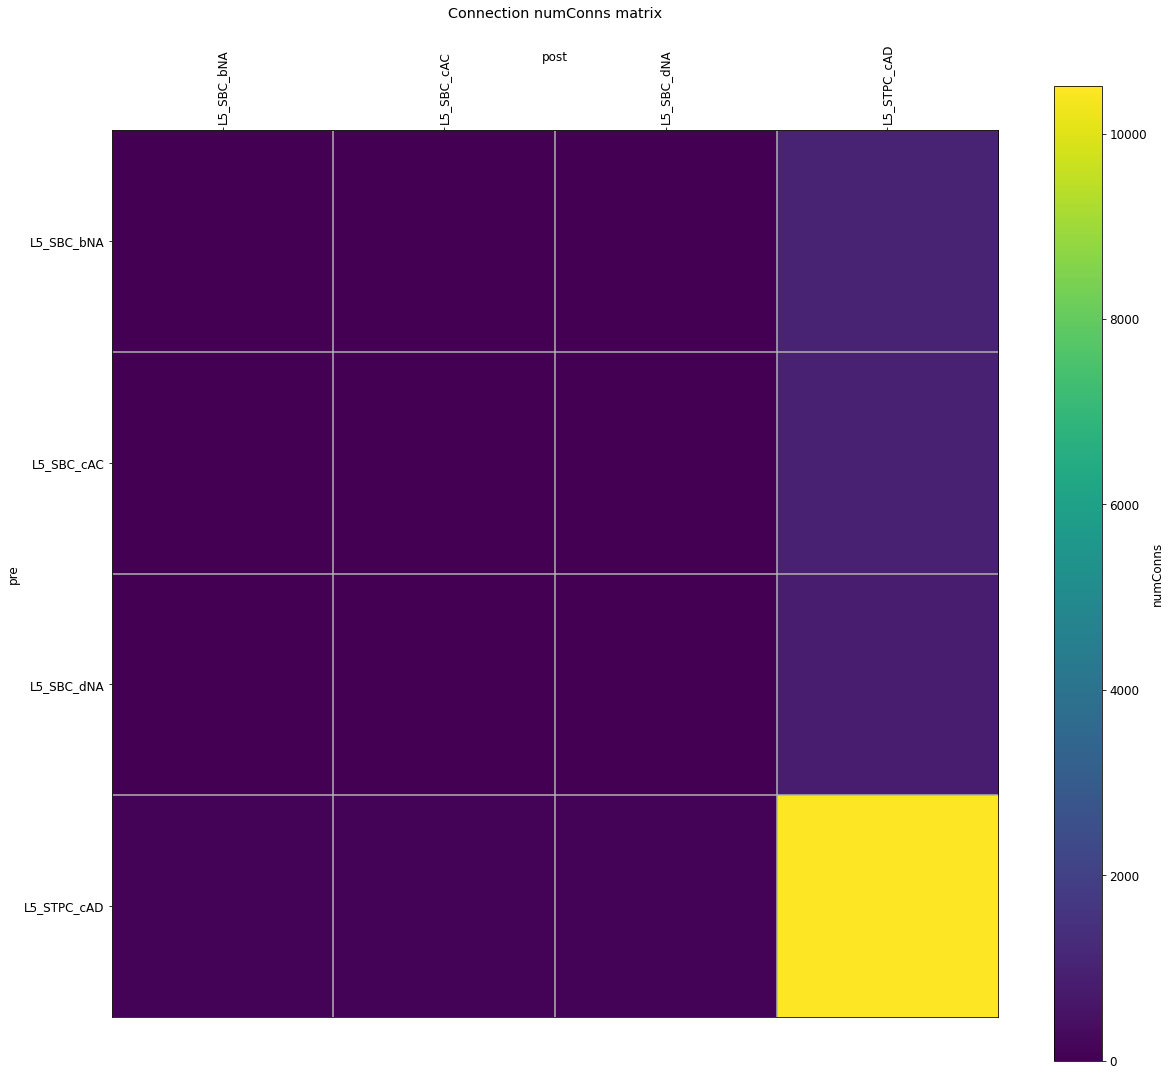

In [40]:
# features = ['numConns','convergence']
test = sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature='numConns', figSize=(18, 18), fontSize=12, saveData=None, 
                               saveFig=True, showFig=False);

In [41]:
connNumber = connData['connNumber']
synperconnNumber = connData['synperconnNumber']
     
connNetPyNE = {}
for pre in subPopLabels:
    connNetPyNE[pre] = {}
    for post in subPopLabels:        
        connNetPyNE[pre][post] = 0
            
i=0
for pre in subPopLabels:
    for cellpre in cfg.popLabelEl[pre]:
        j=0
        for post in subPopLabels:
            for cellpost in cfg.popLabelEl[post]:
                 
                connBBP = float(connNumber[pre][post])
                if connBBP > 0:
                    synperconn = int(synperconnNumber[pre][post]+0.5)       

                    connNetPyNE[pre][post] += test[1]['connMatrix'][i][j]/synperconn
#                 print(i,j,test[1]['connMatrix'][i][j]/synperconn)
                j+=1
        i+=1
  
for pre in subPopLabels:
    for post in subPopLabels:  
            connBBP = float(connNumber[pre][post])      
            if connBBP>0: # pre not in Epops and post not in Epops and 
                print('\t%s->%s  \t - \t  BBP = %5.1f   \t    NetPyNE = %5.1f  \t   Error = %5.1f' % (pre,post,connBBP,connNetPyNE[pre][post],100*(connNetPyNE[pre][post]-connBBP)/connBBP),'%')


	L5_SBC->L5_SBC  	 - 	  BBP =   3.6   	    NetPyNE =   4.0  	   Error =  11.1 %
	L5_SBC->L5_STPC  	 - 	  BBP =  88.0   	    NetPyNE = 104.0  	   Error =  18.2 %
	L5_STPC->L5_SBC  	 - 	  BBP =  39.4   	    NetPyNE =  40.0  	   Error =   1.5 %
	L5_STPC->L5_STPC  	 - 	  BBP = 2127.6   	    NetPyNE = 2102.0  	   Error =  -1.2 %


Plotting 2D representation of network cell locations and connections...


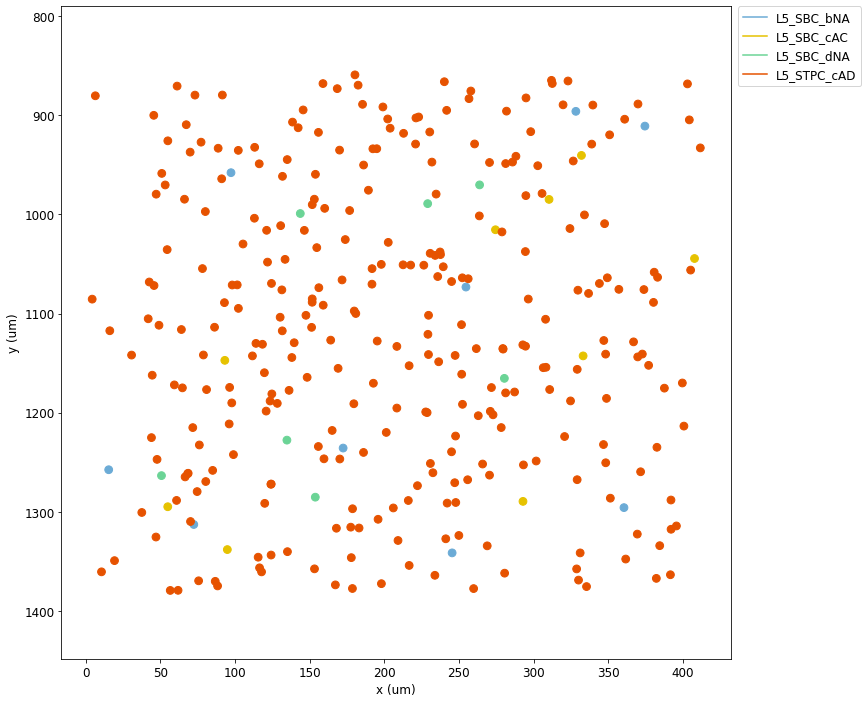

In [42]:
# sim.analysis.plot2Dnet(include=cfg.allpops, view='xy', showConns=True, 
#                                popColors=None, tagsFile=None, figSize=(12, 12), fontSize=8, saveData=None, 
#                                saveFig=False, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=cfg.allpops,view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);
# sim.analysis.plot2Dnet(include=subPopLabels,view='xz', showConns=False, 
#                                popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
#                                saveFig=None, showFig=True, lineWidth=0.1);

## Raster and traces

Plotting raster...


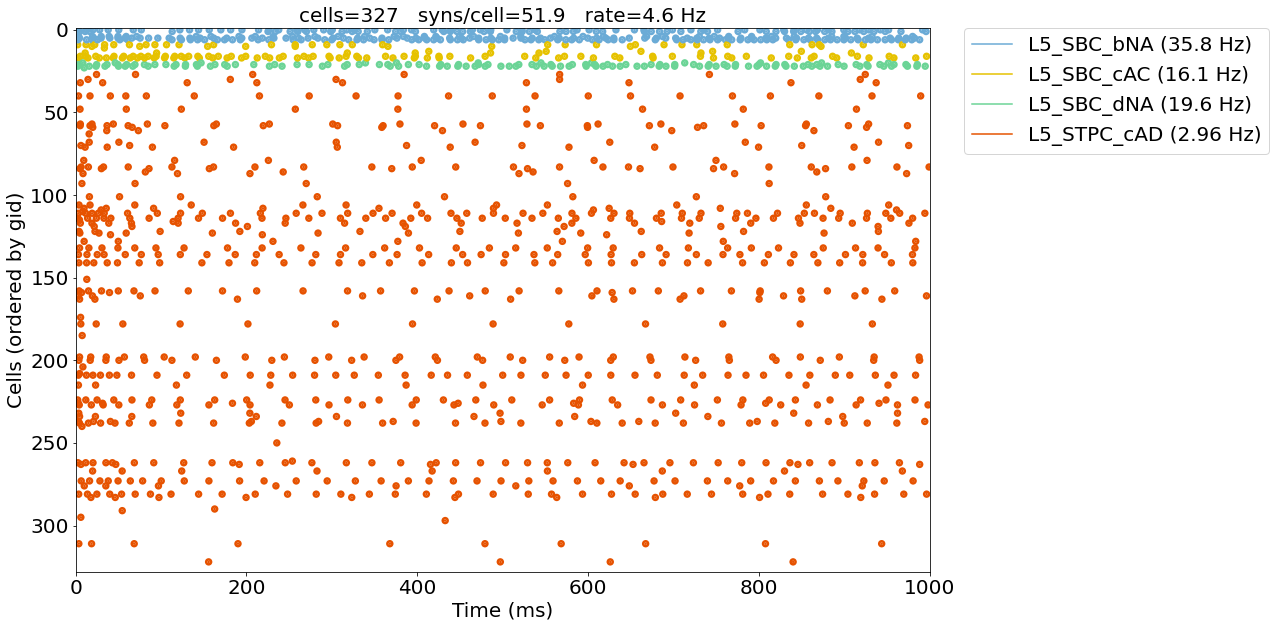

In [43]:
sim.analysis.plotRaster(include=cfg.allpops, timeRange=[0,cfg.duration], orderBy='gid', orderInverse=True, labels='legend', popRates=True, lw=5, marker='.', markerSize=24, figSize=(20, 10), fontSize=20, dpi=300, saveFig=True, showFig=False);

In [44]:
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:
#         print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     

# traces = [(mtype, [i for i in range(0,cfg.popNumber[mtype],int(cfg.popNumber[mtype]/4.5))]) for mtype in subPopLabels]
# traces

Plotting recorded cell traces ... trace


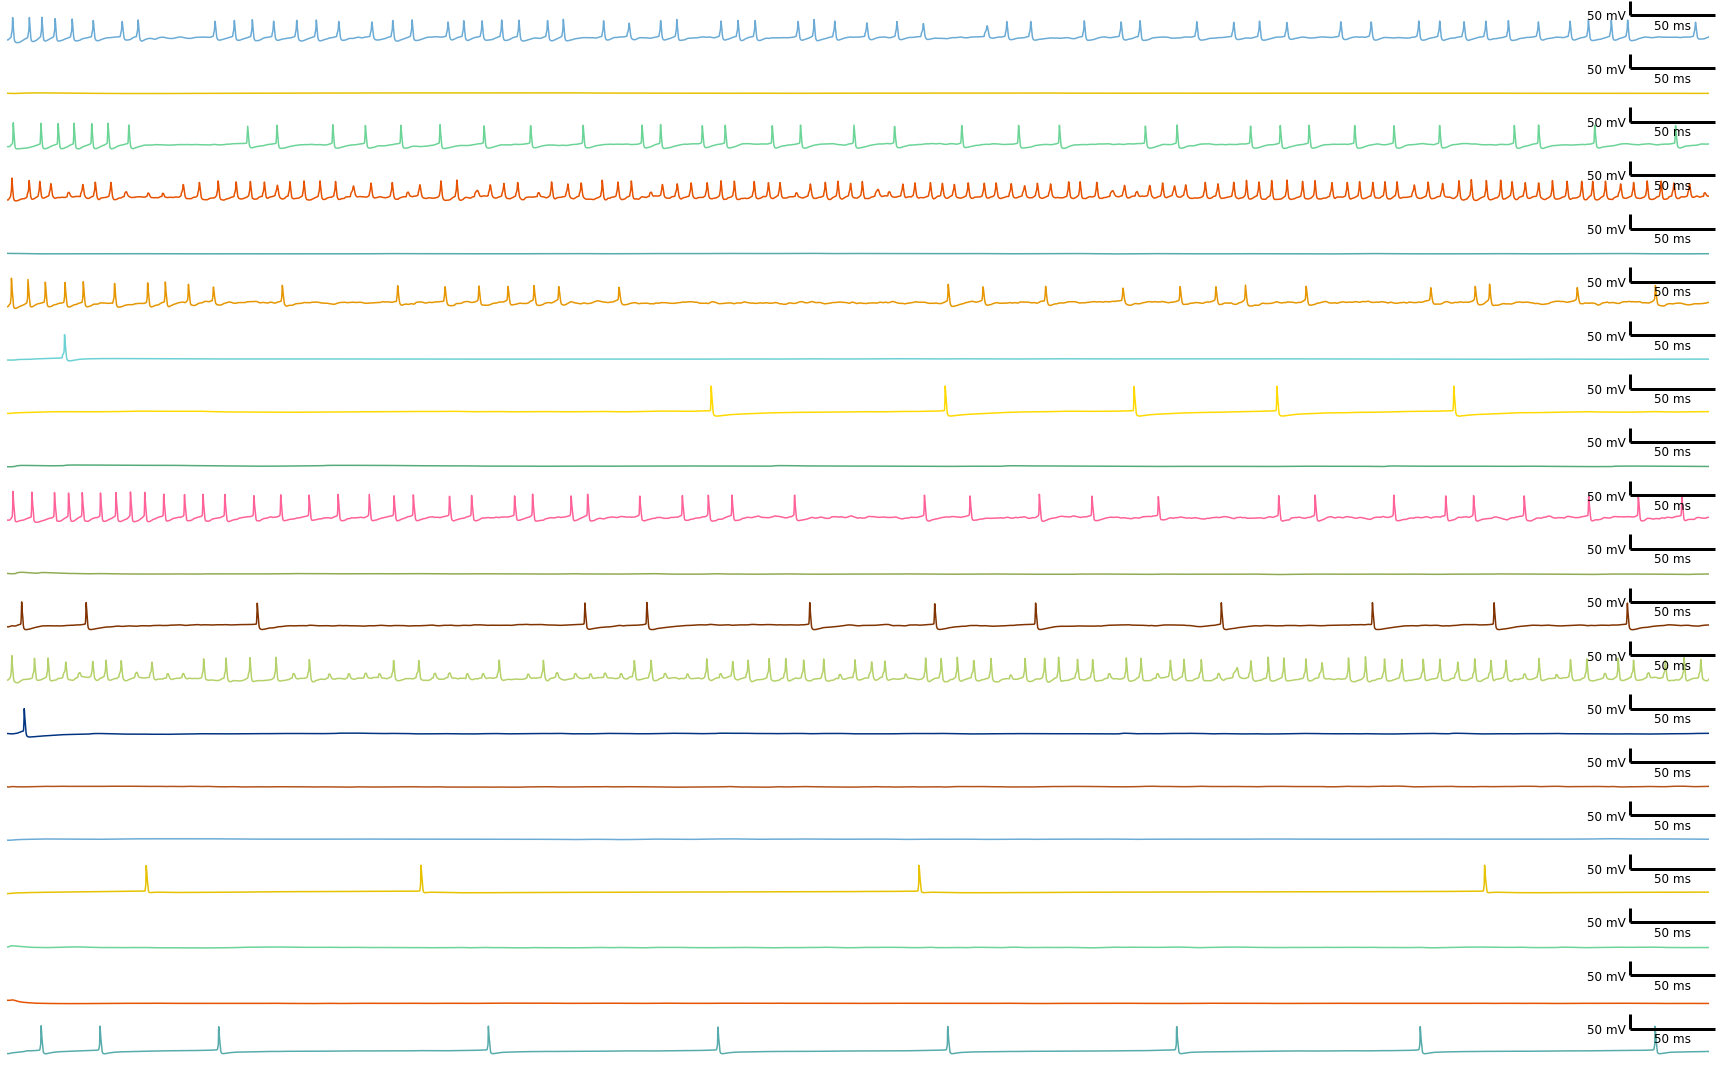

In [45]:
sim.analysis.plotTraces(timeRange=[0,cfg.duration], overlay=False, oneFigPer='trace', ylim=[-90,50], subtitles= False, axis=False, scaleBarLoc=1, figSize=(24, 15), fontSize=12, saveFig=True);



 L5_SBC_bNA   N = 9
Plotting recorded cell traces ... trace
  There was an exception in plotTraces(): 
    [Errno 2] No such file or directory: '../info/test/subNets/subNets_L5_SBC_bNA_Vt.png' 
    (<class 'FileNotFoundError'>, FileNotFoundError(2, 'No such file or directory'), <traceback object at 0x7f6666ffd140>)


 L5_SBC_cAC   N = 9
Plotting recorded cell traces ... trace
  There was an exception in plotTraces(): 
    [Errno 2] No such file or directory: '../info/test/subNets/subNets_L5_SBC_cAC_Vt.png' 
    (<class 'FileNotFoundError'>, FileNotFoundError(2, 'No such file or directory'), <traceback object at 0x7f6664bf2cd0>)


 L5_SBC_dNA   N = 7
Plotting recorded cell traces ... trace
  There was an exception in plotTraces(): 
    [Errno 2] No such file or directory: '../info/test/subNets/subNets_L5_SBC_dNA_Vt.png' 
    (<class 'FileNotFoundError'>, FileNotFoundError(2, 'No such file or directory'), <traceback object at 0x7f6658d997d0>)


 L5_STPC_cAD   N = 302
Plotting recorded 

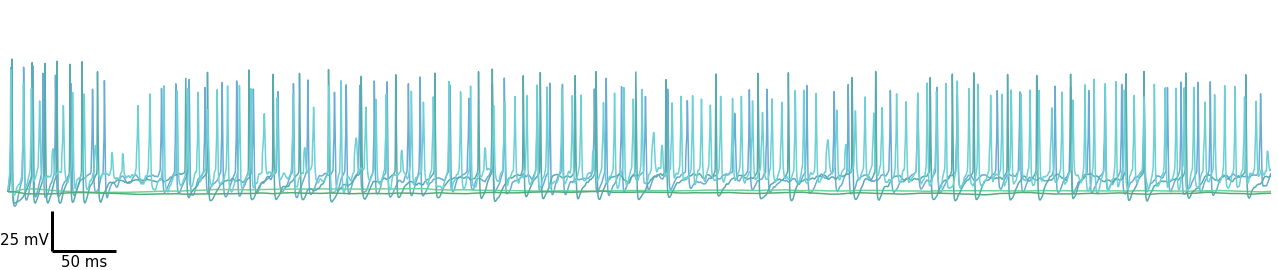

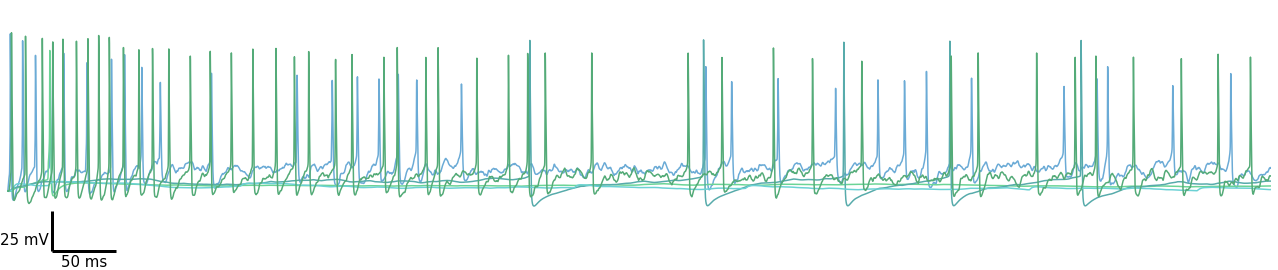

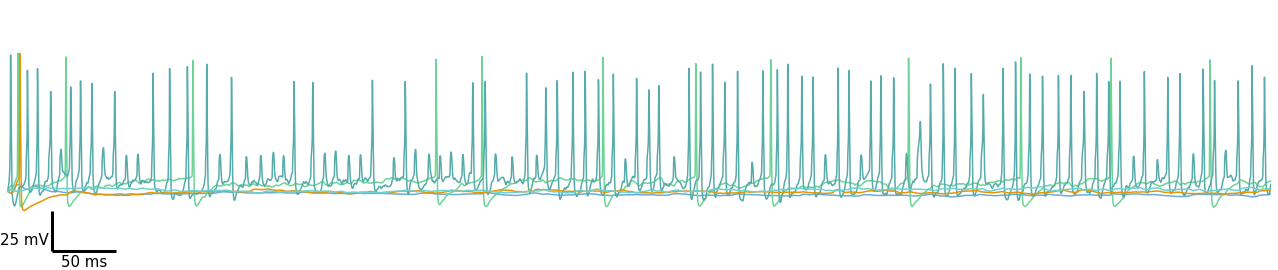

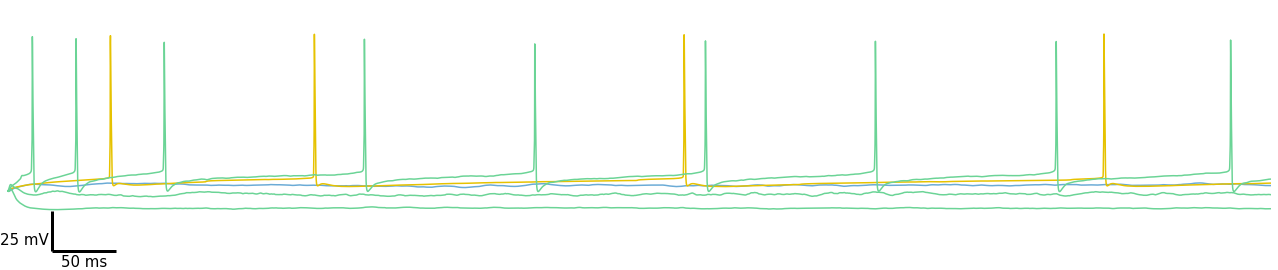

In [46]:
for pops in cfg.cellParamLabels:
    print('\n\n',pops,'  N =',cfg.cellNumber[pops])
    sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', subtitles=False, legend=False, ylim=[-110,50], axis=False, scaleBarLoc=3, figSize=(18, 4), fontSize=15, saveFig='../info/test/'+cfg.simLabel+'/'+cfg.simLabel +'_'+pops+ '_Vt.png');

In [47]:
sim.net.cells[-1].stims

[{source: 'StimSynS1_S_all_EXC->L5_STPC_0', type: 'NetStim', rate: 2331.2646357615895, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[608], hObj: NetStim[301]},
 {source: 'StimSynS1_S_all_EXC->L5_STPC_1', type: 'NetStim', rate: 2622.672715231788, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[1212], hObj: NetStim[603]},
 {source: 'StimSynS1_S_all_EXC->L5_STPC_2', type: 'NetStim', rate: 2914.0807947019866, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[1816], hObj: NetStim[905]},
 {source: 'StimSynS1_S_all_EXC->L5_STPC_3', type: 'NetStim', rate: 3205.488874172185, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[2420], hObj: NetStim[1207]},
 {source: 'StimSynS1_S_all_EXC->L5_STPC_4', type: 'NetStim', rate: 3496.8969536423842, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[3024], hObj: NetStim[1509]},
 {source: 'StimSynS1_S_all_INH->L5_STPC_0', type: 'NetStim', rate:

In [48]:
sim.net.cells[-1].conns

[{preGid: 3, sec: 'dend_4', loc: 0.6613969204231006, synMech: 'S1_IE_STP_Det_5', weight: 0.91, delay: 1.6233838123636521, hObj: NetCon[1873]},
 {preGid: 3, sec: 'dend_8', loc: 0.5505418112767936, synMech: 'S1_IE_STP_Det_5', weight: 0.91, delay: 1.6233838123636521, hObj: NetCon[1874]},
 {preGid: 3, sec: 'dend_12', loc: 0.0763548135909467, synMech: 'S1_IE_STP_Det_5', weight: 0.91, delay: 1.6233838123636521, hObj: NetCon[1875]},
 {preGid: 3, sec: 'dend_18', loc: 0.08423122430615886, synMech: 'S1_IE_STP_Det_5', weight: 0.91, delay: 1.6233838123636521, hObj: NetCon[1876]},
 {preGid: 3, sec: 'dend_26', loc: 0.41077929290113063, synMech: 'S1_IE_STP_Det_5', weight: 0.91, delay: 1.6233838123636521, hObj: NetCon[1877]},
 {preGid: 3, sec: 'dend_33', loc: 0.8139986218549273, synMech: 'S1_IE_STP_Det_5', weight: 0.91, delay: 1.6233838123636521, hObj: NetCon[1878]},
 {preGid: 3, sec: 'dend_36', loc: 0.15188333158386502, synMech: 'S1_IE_STP_Det_5', weight: 0.91, delay: 1.6233838123636521, hObj: NetCon